Los accidentes viales son un problema recurrente en muchas ciudades del mundo, incluyendo la Ciudad de Buenos Aires. Estos accidentes tienen un impacto significativo en la seguridad y el bienestar de los ciudadanos, así como en la economía y la infraestructura de la ciudad. La Ciudad de Buenos Aires (en adelante, CABA), al ser una ciudad densamente poblada y con un alto flujo de tráfico, requiere mucho tiempo y estudio para mejorar las esadisticas en términos de seguridad vial y prevención de accidentes.

Con ayuda de un set de datos extraido de la página del Gobierno de la Ciudad que tiene datos de los siniestros viales ocurridos en este lugar, en la ventana de tiempo de 2015 a 2018, voy a estudiar los casos en conjuntos para sacar conclusiones con vistas a un objetivo puntual; disminuir la cantidad de siniestros en CABA. 

IMPORTO LAS LIBRERIAS A UTILIZAR Y CARGO EL SET DE DATOS CONSEGUIDO EN UN DATAFRAME LLAMADO "sin_df"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium  #needed for interactive map
from folium.plugins import HeatMap


In [3]:
siniestros = 'victimas-siniestros.csv'
sin_df = pd.read_csv(siniestros)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_1980\1239150759.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sin_df = pd.read_csv(siniestros)


Primero voy a ver que features tengo a disposición para comenzar mi estudio

In [4]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33234 entries, 0 to 33233
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   causa                         33234 non-null  object 
 1   rol                           32899 non-null  object 
 2   tipo                          32134 non-null  object 
 3   sexo                          33037 non-null  object 
 4   edad                          32675 non-null  float64
 5   mes                           33197 non-null  float64
 6   periodo                       33234 non-null  int64  
 7   fecha                         33173 non-null  object 
 8   hora                          33217 non-null  object 
 9   lugar_hecho                   29518 non-null  object 
 10  direccion_normalizada         32469 non-null  object 
 11  tipo_calle                    33234 non-null  object 
 12  direccion_normalizada_arcgis  32462 non-null  object 
 13  c

En principio veo que hay muchas columnas que tienen información redundante, voy a trabajar sobre las siguientes columnas: 

- causa
- rol
- tipo
- sexo
- edad
- fecha
- hora
- tipo_calle
- calle1
- calle2
- altura
- direccion_normalizada
- x
- y
- cantidad_victimas
- comuna
- participantes_victimas
- participantes_acusados

In [5]:
sin_df = sin_df[['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']]
sin_df.isnull().sum()

causa                        0
rol                        335
tipo                      1100
sexo                       197
edad                       559
fecha                       61
hora                        17
tipo_calle                   0
calle1                     765
calle2                    8247
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1            1343
participantes_acusados     677
participantes_victimas    1131
dtype: int64

CABA se divide en comunas, estas dividen los distintos "barrios" de capital, cada comuna tiene sus representantes y sus particularidades, hay comunas mas inseguras, otras mas pobladas o mas tranquilas, hay también grandes diferencias economicas entre unas comunas y otras. En este caso, voy a utilizar la división comunal como una ayuda, pero tendría que probar (con graficos o numeros) que esta división es significativa a efectos de este estudio, o sea, no debería asumir que la división comunal influye en la probabilidad de que haya o no un accidente, esto lo voy a estudiar mas adelante. 

Viendo las columnas disponibles, lo primero que me doy cuenta es que cuento con poca información sobre los participantes del siniestro, caso contrario a la información que tengo de la fecha o la geolocalización del mismo. 
Dado esto, voy a tener que enfoncar mi estudio en aspectos que tengan que ver con la peligrosidad del contexto (tipo de vehiculo, ubicación, fecha, clima si extraigo información de una API, etc), ya que no cuento con la información necesaria para realizar perfiles de personas que tuvieron accidentes, ni el estado en el que estaban (por ejemplo, hablando por celular, con/sin cinturon de seguridad, con/sin alcohol en sangre, etc).

Lo primero que voy a estudiar es la columna 'tipo', que indica si el involucrado en el siniestro es un peaton, un auto, una moto, etc.

In [6]:
sin_df['tipo_colision1'].fillna('sin_data',inplace=True)
sin_df['tipo'].fillna('sin_data',inplace=True)

def simplificar_tipocol(tipo):

    if '-' in tipo:
        ac, vi = tipo.split('-')
    else:
        return tipo
    
    if tipo == 'vehiculo - motovehiculo' or tipo == 'motovehiculo - vehiculo':
        return 'motovehiculo - vehiculo'
    elif tipo == 'vehiculo - peaton' or tipo == 'peaton - vehiculo':
        return 'peaton - vehiculo'
    elif tipo == 'vehiculo - bicicleta' or tipo == 'bicicleta - vehiculo':
        return 'bicicleta - vehiculo'
    elif tipo == 'traccion a sangre - vehiculo' or tipo == 'motovehiculo - traccion a sangre' or tipo == 'motovehiculo - tren' or tipo == 'subte - vehiculo':
        return 'sin_data'
    elif 'bicicleta' in tipo:
        return 'bicicleta'
    elif 'peaton' in tipo:
        return 'peaton'
    else:
        return tipo

def simplificar_tipo(tipo):
    
    if tipo == 'auto pfa / movil / gendarmeria / metropolitana / moto movil' or tipo == 'vehiculo oficial':
        st = 'fuerza seguridad'
    elif tipo == 'transporte de cargas / grua' or tipo == 'utilitario':
        st = 'camion'
    elif tipo == 'transporte escolar' or tipo == 'omnibus / minibus':
        st = 'transporte publico'
    elif tipo == 'ambulancia':
        st = 'camioneta'
    elif tipo == 'traccion a sangre' or tipo == 'autobomba' or tipo == 'patineta' or tipo == 'cuatriciclo' or tipo == 'tren / subte' or tipo == 'tren / subte / tranvia' or tipo == 'vehiculo rural' or tipo == 'otros':
        st = 'sin_data'
    else:
        return tipo
    return st

sin_df['tipo'] = sin_df['tipo'].apply(simplificar_tipo)#.astype('|S80')

sin_df['tipo_colision1'] = sin_df['tipo_colision1'].apply(simplificar_tipocol)#.astype('|S80')

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_1980\3893931055.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(g_tipo['tipo'],rotation=45)


[Text(0, 0, 'moto'),
 Text(1, 0, 'peaton'),
 Text(2, 0, 'automovil'),
 Text(3, 0, 'bicicleta'),
 Text(4, 0, 'transporte publico'),
 Text(5, 0, 'sin_data'),
 Text(6, 0, 'taxi/remis'),
 Text(7, 0, 'camioneta'),
 Text(8, 0, 'camion'),
 Text(9, 0, 'fuerza seguridad')]

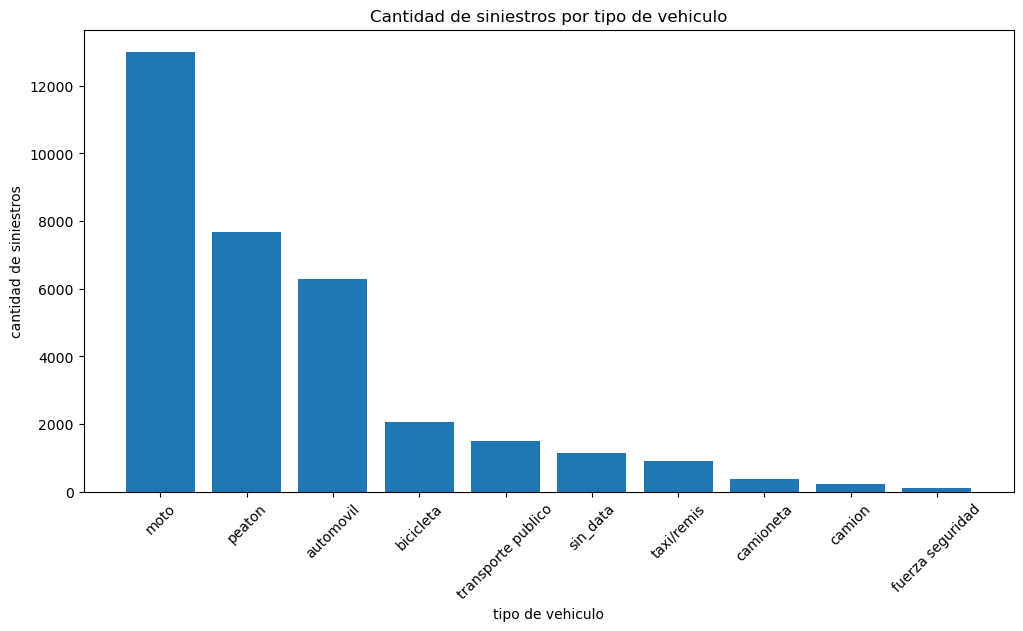

In [7]:
sin_df['cant'] = 1
g_tipo = sin_df.groupby('tipo')['cant'].sum().reset_index().sort_values(by = 'cant', ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(g_tipo['tipo'],g_tipo['cant'])
ax.set_title('Cantidad de siniestros por tipo de vehiculo')
ax.set_xlabel('tipo de vehiculo')
ax.set_ylabel('cantidad de siniestros')
ax.set_xticklabels(g_tipo['tipo'],rotation=45)

Como era de esperar, la moto es el vehiculo con mas siniestros en CABA, desde mi punto de vista hay dos explicaciones, la densidad de motos y la negligencia de los conductores de estas. Suele suceder que quien maneja una moto, en general, intenta maniobras mas peligrosas que los conductores de automovil, por la practicidad y facilidad del propio vehiculo. En este sentido, el conductor de moto de CABA se suele dar mas licencias que el conductor de un auto, hasta el punto de estar fuera de lo que indica la ley de tránsito. 

En este punto, puedo ver con comparaciones, si la columna sexo tiene alguna implicancia en el estudio de la probabilidad de accidente. En principio puedo pensar que los accidentes de peatones tendrán un porcentaje similar de hombres y mujeres, pero en el caso de los autos y motos, es posible que no haya la misma cantidad de conductores, por lo que pueden llegar a dar diferente las comparaciones por sexo. 

Text(0, 0.5, 'Cantidad de siniestros')

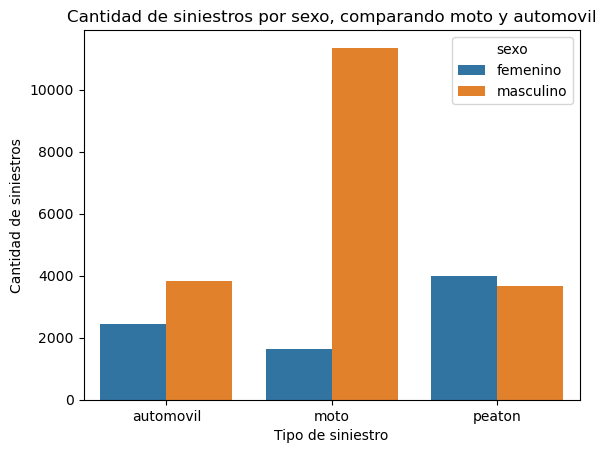

In [8]:
motos_autos_peat = sin_df.loc[(sin_df['tipo']=='moto') | (sin_df['tipo']=='automovil') | (sin_df['tipo']=='peaton')]
g_motos_autos_peat = motos_autos_peat.groupby(['tipo','sexo'])['cant'].sum().reset_index()

ax = sns.barplot(data=g_motos_autos_peat, x='tipo', y='cant', hue='sexo')
ax.set_title('Cantidad de siniestros por sexo, comparando moto y automovil')
ax.set_xlabel('Tipo de siniestro')
ax.set_ylabel('Cantidad de siniestros')

Efectivamente veo una paridad en los accidentes de peatones, y una gran diferencia en los accidentes de moto, asumo en este punto que es por la cantidad de conductores de cada sexo en este determinado vehículo. Para que esta columna sea significativa en una predicción, debería agregar datos externos sobre los porcentajes de conductores de cada sexo por vehiculo.

Puedo notar que tengo poca información del contexto del siniestro, por lo que voy a agregar información sobre el clima del momento del siniestro a mi set de datos. Esta información la voy a bajar del sitio de la NASA en formato csv y luego la importaré y mergearé utilizando el dato de la fecha. Esto me ayudará a entender la implicancia del contexto en los siniestros de CABA. Utilizaré datos como la visibilidad, temperatura, humedad, etc.

In [9]:
clima = 'clima.csv'
clima_df = pd.read_csv(clima)

Para lograr este merge, tendre que tener las claves en el mismo formato. Por el EDA en anteriores entregas, pude notar que la columna "fecha" viene en 2 posibles formatos; DD-MM-AAAA y MM/DD/AA, por lo que usare una función que crearé a continuación para unificar el formato y dividirlo en un arreglo de 3 valores: dia, mes y año

In [10]:
def crear_fecha(fecha):

    if "/" in fecha:
        fecha = fecha.split("/")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        aux = fecha[1]
        fecha[1] = fecha[0]
        fecha[0] = aux
        return fecha
    
    elif "-" in fecha:
        fecha = fecha.split("-")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        fecha[2] = 2000 + fecha[2]
        return fecha


def dia(d):
    return d[0]

def mes(d):
    return d[1]

def anio(d):
    return d[2]

In [11]:
sin_df = sin_df.dropna(subset='fecha')
sin_df['fecha_norm'] = sin_df['fecha'].apply(crear_fecha)

sin_df['d'] = sin_df['fecha_norm'].apply(dia)
sin_df['m'] = sin_df['fecha_norm'].apply(mes)
sin_df['a'] = sin_df['fecha_norm'].apply(anio)

In [12]:
[sin_df.d.max(),
sin_df.m.max(),
sin_df.a.max()]

[31, 12, 2018]

In [13]:
sin_df = sin_df.merge(clima_df,how='left',left_on=['d','m','a'],right_on=['DY','MO','YEAR'])
sin_df.head(2)

,causa,rol,tipo,sexo,edad,fecha,hora,tipo_calle,calle1,calle2,...,DY,QV2M,RH2M,PRECTOTCORR,T2M,TS,WS2M,CLRSKY_SFC_SW_DWN,PS,WS10M
0,homicidio,conductor,moto,NaN,NaN,2/14/2015,19:00:00,calle,cafayate,"garcia grande de zequeira, severo",...,14,9.03,60.06,0.00,21.71,23.18,3.62,8.08,101.66,5.15
1,homicidio,NaN,sin_data,NaN,NaN,2/25/2015,3:00:00,avenida,"lugones, leopoldo av.","udaondo, guillermo av.",...,25,13.79,79.12,1.26,23.12,23.25,4.02,7.29,101.14,5.94


In [14]:
tipo_clima= sin_df.loc[(sin_df.tipo=='automovil') | (sin_df.tipo=='bicicleta') | (sin_df.tipo=='moto') | (sin_df.tipo=='peaton')].groupby('tipo')[['QV2M','WS2M','RH2M','PRECTOTCORR','TS','CLRSKY_SFC_SW_DWN','PS','WS10M']].mean()
tipo_clima

,QV2M,WS2M,RH2M,PRECTOTCORR,TS,CLRSKY_SFC_SW_DWN,PS,WS10M
tipo,,,,,,,,
automovil,8.982003,2.670045,74.090821,2.875986,17.440807,6.013552,101.373322,4.005001
bicicleta,9.116249,2.651242,74.072216,2.385611,17.739795,6.042094,101.357828,3.986167
moto,8.983601,2.671752,73.761621,2.526521,17.541401,6.067530,101.371555,4.008829
peaton,8.967430,2.689969,74.541847,2.925704,17.276569,5.957214,101.364878,4.036560


Comparando los tipos de vehiculos involucrados en siniestros, agregando el promedio de los valores climaticos, puedo notar una variación importante en la columna 'PRECTOTCORR' entre bicicleta, moto y los demas tipos.
Tendré que comparar las demas variables, ya que esta no parece ser decisiva en este feature.

In [15]:
comuna_clima = sin_df.groupby('comuna')[['QV2M','WS2M','RH2M','PRECTOTCORR','TS','CLRSKY_SFC_SW_DWN','PS','WS10M']].mean()
comuna_clima

,QV2M,WS2M,RH2M,PRECTOTCORR,TS,CLRSKY_SFC_SW_DWN,PS,WS10M
comuna,,,,,,,,
1.0,9.079018,2.679173,74.166440,2.702082,17.599334,6.052177,101.353869,4.019718
2.0,8.826160,2.686405,73.393444,2.538219,17.336025,6.059026,101.369026,4.029145
3.0,9.011988,2.672209,73.869032,2.815978,17.505552,6.093917,101.349967,4.005211
4.0,9.055755,2.678155,74.359790,3.175679,17.461391,6.004800,101.359378,4.022951
5.0,8.956827,2.697194,73.787139,3.051484,17.463888,6.033185,101.352049,4.046641
6.0,9.232651,2.676884,74.367931,2.757537,17.847852,6.117828,101.359685,4.010283
7.0,9.042510,2.688178,73.739312,2.816763,17.699091,6.184710,101.363428,4.028021
8.0,9.049779,2.688181,74.122689,2.964544,17.599743,6.077653,101.348616,4.024372
9.0,8.894038,2.700469,73.975945,3.037890,17.362562,6.010402,101.369953,4.048998


En el estudio de comunas veo que algunas comunas son sensibles a cambios en el clima.

Es un poco dificil notar cuales son las columnas mas sensibles a la discriminación por comuna, por lo que usare el valor absoluto del cambio y lo visualizare en un heatmap

In [16]:
medias_clima = sin_df[['QV2M','WS2M','RH2M','PRECTOTCORR','TS','CLRSKY_SFC_SW_DWN','PS','WS10M']].mean()
medias_clima.to_frame().transpose()

,QV2M,WS2M,RH2M,PRECTOTCORR,TS,CLRSKY_SFC_SW_DWN,PS,WS10M
0,9.001507,2.683351,74.05636,2.764156,17.487763,6.040257,101.36368,4.025199


<AxesSubplot:>

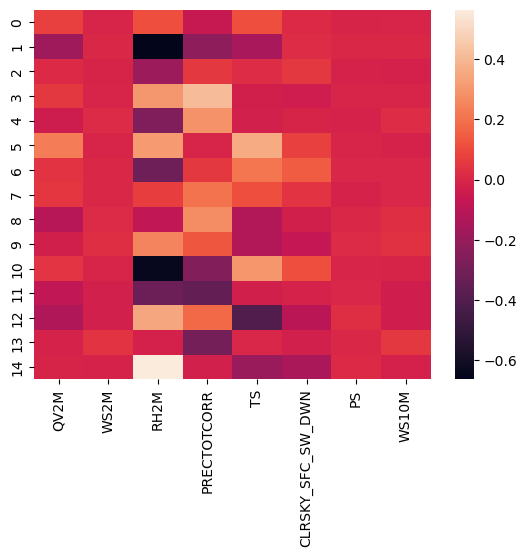

In [17]:
comuna_clima = comuna_clima - medias_clima

sns.heatmap(comuna_clima.reset_index().drop(columns='comuna'))

Puedo notar diferencias significativas en algunos valores, especialmente en las columnas "humedad" y "precipitacion"

Con esto concluyo que voy a usar estas columnas, incluyendo la columna "TS" también, en mis entregas para el trabajo final, ya que seguramente aporten información a la hora de hacer predicciones. 

También resta hacer la comparación en el caso de fallecimiento o lesiones, y en otros valores importantes, para ver la influencia del clima en los siniestros. 

Para que esta información agregada tenga mas peso, debería tener en cuenta la hora (para que la información del clima sea mas acertada).

Ya que estoy estudiando la columna 'comuna', voy a comparar la cantidad de choques por tipo en cada comuna.

In [18]:
chocados = sin_df.loc[sin_df['tipo'].str.contains('automovil|peaton|bicicleta|moto')]
chocados2 = chocados.groupby(['comuna','tipo'])['cant'].sum().reset_index()

In [19]:
total_comunas = chocados.groupby('comuna')['cant'].sum().reset_index().dropna()
total_comunas = total_comunas.sort_values(by='cant',ascending=False)

Text(0, 0.5, 'Porcentaje de siniestros')

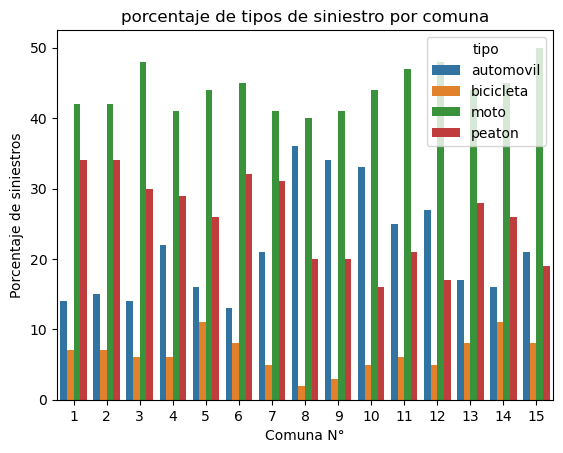

In [20]:
#chocados2.drop(columns='comuna',inplace=True)
chocados2 = chocados2.merge(total_comunas,right_on='comuna',left_on='comuna')

chocados2['porcentaje'] = ((chocados2['cant_x']/chocados2['cant_y'])*100).astype(int)
chocados2 = chocados2[['comuna','tipo','porcentaje']]
chocados2['comuna'] = chocados2['comuna'].astype(int).astype(str)

ax = sns.barplot(chocados2, x='comuna',y='porcentaje',hue='tipo')
ax.set_title('porcentaje de tipos de siniestro por comuna')
ax.set_xlabel('Comuna N°')
ax.set_ylabel('Porcentaje de siniestros')

Los valores del clima "humedad" y "precipitacion" mostraron ser un factor no menor en los accidentes de transito, como era de esperar por obvias razones. 

La diferenciación del tipo de siniestro en cada comuna también sera un dato clave a la hora de hacer predicciones, ya que por lo visto en el último gráfico, varía mucho en algunas comunas el porcentaje de cada tipo. 

Otras columnas como el sexo mostraron gran variación en sus visualizaciones segun el tipo de siniestro, pero asumimos que esto es por la gran diferencia de porcentaje de conductores de cada sexo (hay muchos mas hombres manejando motos en CABA que mujeres).

En conclusión, el set de datos elegidos, en principio tiene una gran cantidad de información útil para hacer predicciones con un modelo de machine learning, utilizando algunas columnas como 'comuna', 'tipo_colision1', 'precipitacion', 'causa', 'tipo_calle', se pueden inferir los datos de otras columnas como el horario de la colision o el rango etareo del involucrado. A esto apuntaré en futuras entregas. 


<AxesSubplot:xlabel='x'>

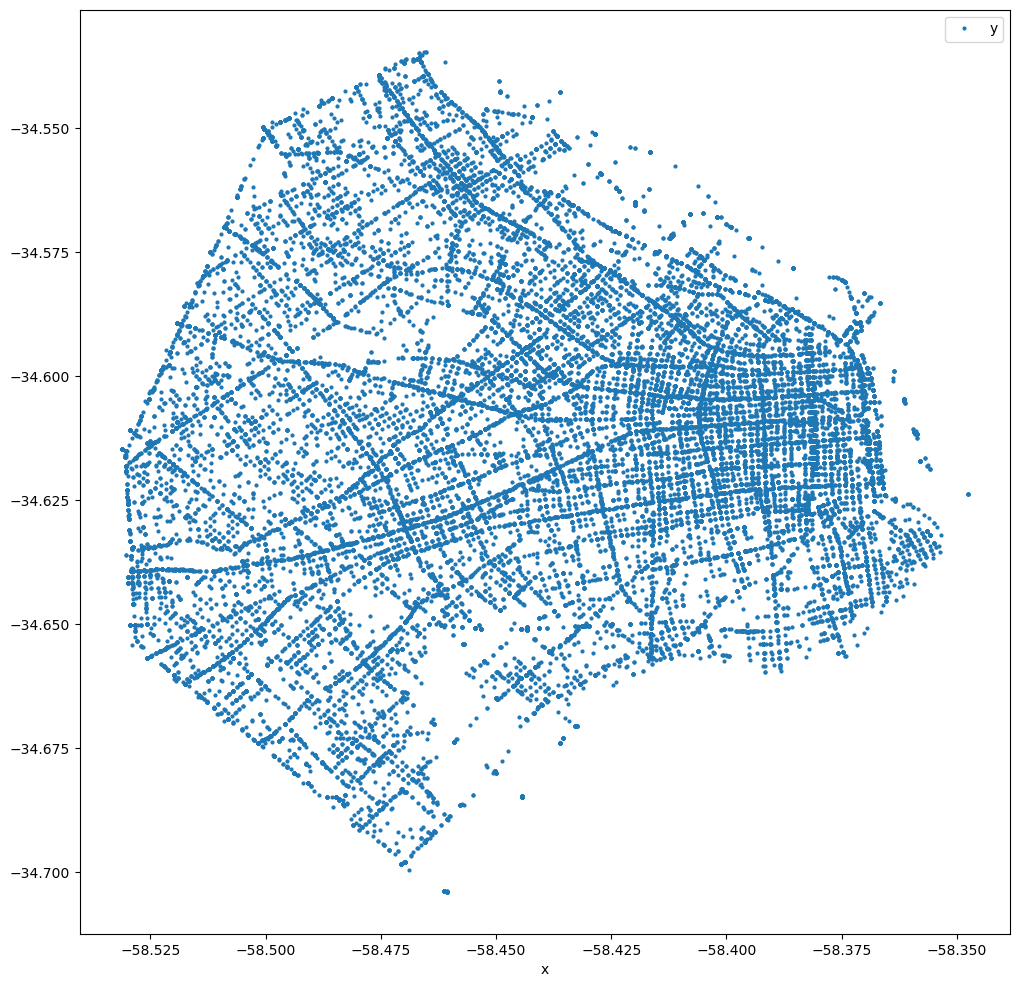

In [39]:
sin_df = sin_df.dropna(subset='x')
sin_df.plot(x='x', y='y',style='o',figsize=(12,12),markersize=2)


En este último gráfico, para concluir el estudio del set de datos, puedo ver como se distribuyen los siniestros en la ciudad, viendo que en las avenidas es donde se produce la mayor cantidad de siniestros, pudiendo diferenciar los tramos con un aumento significativo de estos.